# Mean-Variance Portfolio Optimization Pipeline

In [90]:
# IMPORTS

import os
import squarify
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdmhttps://github.com/FrederikDanielsen/mean_variance_portfolio_optimization
from scipy.optimize import minimize
from matplotlib.colors import TwoSlopeNorm
from typing import Tuple, Optional, List, Union, Dict, List

## Control Panel

In [91]:
# CHANGE THESE VALUES TO FIT YOUR NEEDS

trading_days_per_year = 252
number_of_stocks_in_portfolio = 10  # Set to None if unlimitted (Must be at least 2)
number_of_historical_years = None  # Set to None if you want to use as much data as possible
portfolio_precision = 10  # Set the number of digits that the portfolio percentages will be rou nded to
risk_free_rate_annual = 0.02

## Functions used in the notebook

In [92]:


# Functions used in the Notebook


#--------------------------------
# Helper Functions
#--------------------------------

def make_positive_definite(
    matrix: pd.DataFrame, epsilon: float = 1e-6
) -> pd.DataFrame:
    """
    Ensures a matrix is positive definite by adding a small value (epsilon) to its diagonal.
    
    Parameters:
    - matrix (pd.DataFrame): Input covariance matrix.
    - epsilon (float): Small positive value to add to the diagonal.
    
    Returns:
    - pd.DataFrame: A positive definite version of the input matrix.
    """
    # Convert to numpy array for manipulation
    matrix_np = matrix.values

    # Add epsilon to the diagonal
    positive_definite_matrix = matrix_np + epsilon * np.eye(matrix.shape[0])
    
    # Return as pandas DataFrame with the same index and columns
    return pd.DataFrame(positive_definite_matrix, index=matrix.index, columns=matrix.columns)

def is_positive_definite(
    matrix: pd.DataFrame
) -> bool:
    """
    Checks if a matrix is positive definite.
    
    Parameters:
    - matrix (pd.DataFrame): Input matrix.
    
    Returns:
    - bool: True if the matrix is positive definite, False otherwise.
    """
    try:
        # Perform Cholesky decomposition
        np.linalg.cholesky(matrix.values)
        return True
    except np.linalg.LinAlgError:
        return False

def weights_to_dict(
    weights: Union[np.ndarray, List[float]], tickers: List[str]
) -> Dict[str, float]:
    """
    Converts a list or NumPy array of weights and a list of ticker symbols into a dictionary.

    Parameters:
        weights (Union[np.ndarray, List[float]]): An array or list of numerical weights.
        tickers (List[str]): A list of ticker symbols corresponding to the weights.

    Returns:
        Dict[str, float]: A dictionary mapping each ticker symbol to its corresponding weight.

    Raises:
        ValueError: If the lengths of `weights` and `tickers` do not match.
        TypeError: If `weights` is not a list or a NumPy array, or if `tickers` is not a list of strings.
    """
    # Input validation
    if not isinstance(weights, (list, np.ndarray)):
        raise TypeError("weights must be a list or a numpy array.")

    if not isinstance(tickers, list) or not all(isinstance(ticker, str) for ticker in tickers):
        raise TypeError("tickers must be a list of strings.")

    if len(weights) != len(tickers):
        raise ValueError("weights and tickers must have the same length.")

    # Convert weights to float and create the dictionary
    ticker_weight_dict = {ticker: float(weight) for ticker, weight in zip(tickers, weights)}

    return ticker_weight_dict

def round_portfolio(
    portfolio: Dict[str, float], 
    decimals: int = 4
) -> Dict[str, float]:
    """
    Normalize and round portfolio weights to a specified number of decimals.

    The function rounds each weight in the portfolio to the given number of decimals,
    and ensures the total weight does not exceed 1.0. If the total exceeds 1.0 after
    rounding, the weights are proportionally scaled down so that their sum equals 1.0.

    Parameters:
    -----------
    portfolio : Dict[str, float]
        A dictionary where the keys are asset tickers (e.g., 'AAPL') and the values are
        their respective weights, which should approximately sum to 1.0.
    decimals : int
        The number of decimal places to which weights are rounded. Defaults to 4.

    Returns:
    --------
    Dict[str, float]
        A dictionary with rounded and potentially scaled weights, ensuring the sum is <= 1.0.
    """
    # Input validation
    if not isinstance(portfolio, dict):
        raise ValueError("Portfolio must be a dictionary.")
    if not all(isinstance(ticker, str) for ticker in portfolio.keys()):
        raise ValueError("All keys in the portfolio must be strings.")
    if not all(isinstance(weight, (int, float)) for weight in portfolio.values()):
        raise ValueError("All values in the portfolio must be integers or floats.")
    if not isinstance(decimals, int) or decimals < 0:
        raise ValueError("Decimals must be a non-negative integer.")

    # Step 1: Round each weight
    rounded_weights = {
        ticker: round(weight, decimals) for ticker, weight in portfolio.items()
    }

    # Step 2: Check if total exceeds 1.0
    total_weight = sum(rounded_weights.values())

    if total_weight > 1.0:
        # Scale all weights proportionally so their sum equals 1.0
        scale_factor = 1.0 / total_weight
        rounded_weights = {
            ticker: round(weight * scale_factor, decimals)
            for ticker, weight in rounded_weights.items()
        }

    # Step 3: Ensure the final sum is <= 1.0 (due to potential rounding errors)
    final_total = sum(rounded_weights.values())
    if final_total > 1.0:
        scale_factor = 1.0 / final_total
        rounded_weights = {
            ticker: round(weight * scale_factor, decimals)
            for ticker, weight in rounded_weights.items()
        }

    return rounded_weights

def round_and_prune_portfolio(
    portfolio: Dict[str, float], decimals: int = 4
) -> Dict[str, float]:
    """
    Adjusts a portfolio's asset weights by rounding, pruning zero weights, 
    and scaling down to ensure the total weight does not exceed 1.0.
    
    If all weights are reduced to zero after rounding, the largest asset 
    from the original portfolio is set to a weight of 1.0.

    Parameters
    ----------
    portfolio : Dict[str, float]
        A dictionary with asset names as keys and their corresponding weights as values. 
        The sum of weights is expected to be approximately 1.0.
    decimals : int
        The number of decimal places to round weights. Defaults to 4.

    Returns
    -------
    Dict[str, float]
        A new dictionary containing assets with non-zero weights and a total weight ≤ 1.0.
    """
    # Input validation
    if not isinstance(portfolio, dict) or not all(isinstance(k, str) and isinstance(v, (int, float)) for k, v in portfolio.items()):
        raise ValueError("Portfolio must be a dictionary with string keys and numeric (int or float) values.")
    if not isinstance(decimals, int) or decimals < 0:
        raise ValueError("Decimals must be a non-negative integer.")
    if sum(portfolio.values()) <= 0:
        raise ValueError("Portfolio weights must sum to a positive value.")
    
    # Step 1: Round each asset's weight to the specified number of decimals
    rounded_weights = {asset: round(weight, decimals) for asset, weight in portfolio.items()}
    
    # Step 2: Remove assets with zero weight after rounding
    pruned_weights = {asset: weight for asset, weight in rounded_weights.items() if weight > 0.0}
    
    # Handle edge case: If all weights are zero after pruning
    if not pruned_weights:
        largest_asset = max(portfolio, key=portfolio.get)  # Find the asset with the highest original weight
        return {largest_asset: 1.0}
    
    # Step 3: Scale weights down if their total exceeds 1.0
    total_weight = sum(pruned_weights.values())
    if total_weight > 1.0:
        scale_factor = 1.0 / total_weight
        scaled_weights = {asset: round(weight * scale_factor, decimals) for asset, weight in pruned_weights.items()}
        
        # Remove any weights that became zero after scaling
        scaled_weights = {asset: weight for asset, weight in scaled_weights.items() if weight > 0.0}
        
        # Handle edge case: If scaling results in no valid weights
        if not scaled_weights:
            largest_asset = max(pruned_weights, key=pruned_weights.get)
            return {largest_asset: 1.0}
        
        pruned_weights = scaled_weights
    
    # Ensure the sum of weights is ≤ 1.0 and all weights are non-zero
    return pruned_weights


#--------------------------------
# Data Processing and Computation
#--------------------------------

def load_price_data(
    file_path: str,
    years: Optional[int] = None,
    trading_days_per_year: int = 252
) -> pd.DataFrame:
    """
    Load and preprocess price data from a CSV file.

    This function reads a CSV file containing price data, processes it to filter rows, 
    handles missing values, and sets the 'Date' column as the index.

    Parameters:
    - file_path (str): Path to the CSV file containing price data.
    - years (Optional[int]): Number of years of data to retain. If None, all data is retained.
    - trading_days_per_year (int): Number of trading days in a year. Default is 252.

    Returns:
    - pd.DataFrame: A DataFrame with processed price data.
    """

    # Input argument validation
    if not isinstance(file_path, str):
        raise TypeError("file_path must be a string.")
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    if years is not None:
        if not isinstance(years, int) or years <= 0:
            raise ValueError("years must be a positive integer or None.")

    if not isinstance(trading_days_per_year, int) or trading_days_per_year <= 0:
        raise ValueError("trading_days_per_year must be a positive integer.")

    # Load CSV with parsed dates
    data = pd.read_csv(
        file_path,
        parse_dates=['Date'],
        dayfirst=False  # Set to True if 'Date' is in 'DD-MM-YYYY' format
    )

    # Sort by 'Date' in ascending order
    data = data.sort_values('Date')


    # Set 'Date' as the index
    data.set_index('Date', inplace=True)

    # Drop rows with more than 90% missing values
    non_nan_threshold = int(len(data.columns) * 0.1)  # At least 10% non-NaN values
    data = data.dropna(thresh=non_nan_threshold)

    # Trim DataFrame to the last row with no missing values
    last_complete_row = data.dropna().index.max()
    if pd.notna(last_complete_row):
        data = data.loc[:last_complete_row]

    # Summarize the loaded data
    if not data.empty:
        start_date = data.index.min()
        end_date = data.index.max()
        total_days = (end_date - start_date).days

        summary_years = total_days // 365
        remaining_days = total_days % 365
        summary_months = remaining_days // 30
        summary_days = remaining_days % 30

        asset_count = len(data.columns)

        print(f"Loaded data: {summary_years} years, {summary_months} months, {summary_days} days "
              f"of data with {asset_count} assets.")
    else:
        print("Loaded data: No data available after preprocessing.")

    return data

def compute_returns_and_covariance_matrix(
    price_data: pd.DataFrame
) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame]:
    """
    Compute daily return statistics from a DataFrame of daily prices.

    This function calculates:
    1. Daily returns as percentage changes in prices.
    2. The mean vector of daily returns.
    3. The covariance matrix of daily returns.

    Parameters:
    - price_data (pd.DataFrame): A DataFrame containing daily prices, where each column
      represents a financial instrument and rows represent time periods.

    Returns:
    - Tuple:
      - daily_returns (pd.DataFrame): A DataFrame of percentage changes in prices.
      - mean_returns (pd.Series): A Series containing the mean daily returns for each instrument.
      - cov_matrix (pd.DataFrame): A DataFrame representing the covariance matrix of daily returns.
    """
    # Input validation
    if not isinstance(price_data, pd.DataFrame):
        raise TypeError("price_data must be a pandas DataFrame.")
    
    if price_data.empty:
        raise ValueError("price_data must not be empty.")
    
    if not all(price_data.dtypes.apply(lambda x: pd.api.types.is_numeric_dtype(x))):
        raise ValueError("All columns in price_data must contain numeric data.")
    
    if price_data.shape[1] < 2:
        raise ValueError("price_data must have at least two columns for covariance calculation.")

    # Calculate daily returns as percentage changes in prices
    daily_returns = price_data.pct_change(fill_method=None).dropna()

    # Check if daily_returns contains sufficient data after processing
    if daily_returns.empty:
        raise ValueError("Insufficient data after calculating percentage changes in price_data.")

    # Calculate the mean vector of daily returns
    mean_returns = daily_returns.mean()

    # Calculate the covariance matrix of daily returns
    cov_matrix = daily_returns.cov()

    return daily_returns, mean_returns, cov_matrix

def annualize_returns_and_covaraince_matrix(
    mean_returns_daily: pd.Series,
    covariance_matrix_daily: pd.DataFrame,
    trading_days_per_year: int = 252
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Annualize daily return for financial analysis.

    Parameters:
        daily_returns (np.ndarray): Array of mean daily returns.
        daily_covariance (np.ndarray): Daily covariance matrix of returns.
        trading_days_per_year (int): Number of trading days in a year. Default is 252 (typical for stock markets).

    Returns:
        Tuple[np.ndarray, np.ndarray]:
            - Annualized mean returns (np.ndarray).
            - Annualized covariance matrix (np.ndarray).
    """
    # Input validation
    if not isinstance(mean_returns_daily, pd.Series):
        raise TypeError("daily_returns must be a pandas series.")

    if not isinstance(covariance_matrix_daily, pd.DataFrame):
        raise TypeError("daily_covariance must be a pandas data frame.")

    if not isinstance(trading_days_per_year, int):
        raise TypeError("trading_days_per_year must be an integer.")

    if trading_days_per_year <= 0:
        raise ValueError("trading_days_per_year must be a positive integer.")

    if mean_returns_daily.ndim != 1:
        raise ValueError("daily_returns must be a one-dimensional numpy array.")

    if covariance_matrix_daily.ndim != 2:
        raise ValueError("daily_covariance must be a two-dimensional numpy array.")

    if covariance_matrix_daily.shape[0] != covariance_matrix_daily.shape[1]:
        raise ValueError("daily_covariance must be a square matrix.")

    if mean_returns_daily.shape[0] != covariance_matrix_daily.shape[0]:
        raise ValueError("The length of daily_returns must match the dimensions of daily_covariance.")

    # Calculate annualized mean returns
    annualized_returns = (1 + mean_returns_daily) ** trading_days_per_year - 1

    # Scale the daily covariance matrix by the number of trading days
    annualized_covariance = covariance_matrix_daily * trading_days_per_year

    return annualized_returns, annualized_covariance

def calculate_portfolio_statistics(
    portfolio_weights: Dict[str, float],
    mean_returns_annual: pd.Series,
    covariance_matrix_annual: pd.DataFrame,
    risk_free_rate: float = 0.02
) -> None:
    """
    Calculate the expected annual return, annual volatility, and Sharpe Ratio of a portfolio,
    given the portfolio weights and already-annualized returns/covariance.

    Parameters
    ----------
    portfolio_weights : dict
        A dictionary where keys are asset IDs and values are their weights in the portfolio.
        The weights should sum to approximately 1.
    mean_returns_annual : pd.Series
        Annualized mean returns of assets.
    covariance_matrix_annual : pd.DataFrame
        Annualized covariance matrix of asset returns.
    risk_free_rate : float, optional
        Annualized risk-free rate for Sharpe Ratio calculation (default is 0.02).

    Returns
    -------
    Optional[Tuple[float, float, float]]
        If successful, returns a tuple of:
        (portfolio_expected_annual_return, portfolio_annual_volatility, portfolio_sharpe_ratio).
        Otherwise, returns None.
    """

    # --------------------------
    # Input Validation
    # --------------------------
    if not isinstance(portfolio_weights, dict) or not portfolio_weights:
        print("Error: Portfolio weights must be a non-empty dictionary.")
        return None

    if not isinstance(mean_returns_annual, pd.Series) or mean_returns_annual.empty:
        print("Error: Annual mean returns must be a non-empty pandas Series.")
        return None

    if not isinstance(covariance_matrix_annual, pd.DataFrame) or covariance_matrix_annual.empty:
        print("Error: Annual covariance matrix must be a non-empty DataFrame.")
        return None

    if not isinstance(risk_free_rate, (int, float)):
        print("Error: Annual risk-free rate must be a numeric value.")
        return None

    # Ensure portfolio weights correspond to assets in mean_returns_annual
    valid_assets = [asset for asset in portfolio_weights if asset in mean_returns_annual.index]
    if not valid_assets:
        print("Error: No matching assets found between portfolio weights and annual returns.")
        return None

    # Normalize portfolio weights to ensure they sum to 1
    weights = np.array([portfolio_weights[asset] for asset in valid_assets])
    weights_sum = weights.sum()
    if abs(weights_sum) < 1e-12:
        print("Error: Total portfolio weight is zero.")
        return None
    weights /= weights_sum

    # Compute portfolio metrics
    portfolio_annual_return = np.dot(weights, mean_returns_annual[valid_assets].values)
    portfolio_annual_volatility = np.sqrt(
        weights.T @ covariance_matrix_annual.loc[valid_assets, valid_assets].values @ weights
    )

    # Avoid division by zero in Sharpe Ratio
    if abs(portfolio_annual_volatility) < 1e-12:
        sharpe_ratio = np.nan
    else:
        sharpe_ratio = (portfolio_annual_return - risk_free_rate) / portfolio_annual_volatility

    # Print and/or return results
    print(f"Portfolio Expected Annual Return: {portfolio_annual_return * 100:.2f}%")
    print(f"Portfolio Annual Volatility (Std Dev): {portfolio_annual_volatility * 100:.2f}%")
    print(f"Portfolio Sharpe Ratio: {sharpe_ratio:.2f}")

    return

def compute_min_variance_portfolio(
    expected_returns: pd.Series,
    covariance_matrix: pd.DataFrame,
    target_return: float,
    max_assets: Optional[int] = None,
    verbose: bool = True
) -> Optional[np.ndarray]:
    """
    Constructs a minimum variance portfolio using the SLSQP solver.

    Parameters:
    - expected_returns (pd.Series): Expected returns of the assets.
    - covariance_matrix (pd.DataFrame): Covariance matrix of asset returns.
    - target_return (float): Desired portfolio return.
    - max_assets (Optional[int]): Maximum number of assets in the portfolio (default is None).
    - verbose (bool): If True, prints detailed optimization logs (default is True).

    Returns:
    - Optional[np.ndarray]: Optimal portfolio weights or None if optimization fails.
    """
    # Input validation
    if not isinstance(expected_returns, pd.Series):
        raise ValueError("expected_returns must be a pandas Series.")
    
    if not isinstance(covariance_matrix, pd.DataFrame):
        raise ValueError("covariance_matrix must be a pandas DataFrame.")
    
    if not isinstance(target_return, (float, int)):
        raise ValueError("target_return must be a float or int.")
    
    if max_assets is not None:
        if not isinstance(max_assets, int) or max_assets <= 0:
            raise ValueError("max_assets must be a positive integer or None.")
    
    if not isinstance(verbose, bool):
        raise ValueError("verbose must be a boolean.")
    
    if expected_returns.empty:
        raise ValueError("expected_returns must not be empty.")
    
    if covariance_matrix.empty:
        raise ValueError("covariance_matrix must not be empty.")
    
    if len(expected_returns) != covariance_matrix.shape[0] or len(expected_returns) != covariance_matrix.shape[1]:
        raise ValueError("Dimensions of expected_returns and covariance_matrix must match.")
    
    if not covariance_matrix.equals(covariance_matrix.T):
        raise ValueError("covariance_matrix must be symmetric.")

    # If max_assets is specified, must be at least 2
    if max_assets is not None:
        if not isinstance(max_assets, int) or max_assets < 2:
            raise ValueError("`max_assets` must be an integer >= 2 or None.")
        if max_assets > len(expected_returns):
            raise ValueError("`max_assets` cannot exceed the number of available assets.")

    # If covariance not positive definite make it
    if not is_positive_definite(covariance_matrix):
        covariance_matrix = make_positive_definite(covariance_matrix)

    num_assets = len(expected_returns)

    # Define the objective function: Portfolio variance
    def portfolio_variance(weights: np.ndarray) -> float:
        return weights.T @ covariance_matrix.values @ weights

    # Define the constraints
    constraints = [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Full investment constraint
        {'type': 'eq', 'fun': lambda weights: weights @ expected_returns.values - target_return}  # Target return constraint
    ]

    # Set bounds for weights (no short-selling)
    weight_bounds = [(0, 1) for _ in range(num_assets)]

    # Initial guess: Equal allocation
    initial_guess = np.ones(num_assets) / num_assets

    # Perform the optimization
    optimization_result = minimize(
        portfolio_variance,
        initial_guess,
        method='SLSQP',
        bounds=weight_bounds,
        constraints=constraints
    )

    if verbose:
        print(f"Optimization status: {optimization_result.message}")

    if not optimization_result.success:
        return None

    optimized_weights = optimization_result.x

    # Post-process: Limit the number of assets if specified
    if max_assets is not None and 1 <= max_assets < num_assets:
        # Retain the top weights based on magnitude
        top_indices = np.argsort(-optimized_weights)[:max_assets]
        sparse_weights = np.zeros_like(optimized_weights)
        sparse_weights[top_indices] = optimized_weights[top_indices]

        # Re-optimize with the reduced set of assets
        reduced_expected_returns = expected_returns.iloc[top_indices]
        reduced_covariance_matrix = covariance_matrix.iloc[top_indices, top_indices]

        # Define reduced objective function
        def reduced_portfolio_variance(weights: np.ndarray) -> float:
            return weights.T @ reduced_covariance_matrix.values @ weights

        # Define reduced constraints
        reduced_constraints = [
            {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
            {'type': 'eq', 'fun': lambda weights: weights @ reduced_expected_returns.values - target_return}
        ]

        # Set bounds and initial guess for reduced problem
        reduced_bounds = [(0, 1) for _ in range(max_assets)]
        reduced_initial_guess = np.ones(max_assets) / max_assets

        reduced_optimization_result = minimize(
            reduced_portfolio_variance,
            reduced_initial_guess,
            method='SLSQP',
            bounds=reduced_bounds,
            constraints=reduced_constraints
        )

        if reduced_optimization_result.success:
            final_weights = np.zeros(num_assets)
            final_weights[top_indices] = reduced_optimization_result.x
            return final_weights
        else:
            return None

    return optimized_weights

def compute_max_sharpe_ratio_portfolio(
    expected_returns: pd.Series,
    covariance_matrix: pd.DataFrame,
    risk_free_rate: float = 0.02,
    alpha: float = 0.5,
    max_iterations: int = 1000,
    tolerance: float = 1e-6,
    verbose: bool = True,
    max_assets: int = None,
    k: int = 50,  # Number of samples per iteration
    delta_initial: float = 1.5,  # Initial standard deviation for sampling
    return_optimization_result: bool = False  # Optional parameter for debugging
) -> np.ndarray:
    """
    Constructs a portfolio with the maximum Sharpe Ratio using a stochastic
    variance targeting approach (optionally constrained by `max_assets`).

    Parameters
    ----------
    expected_returns : pd.Series
        Expected returns of the assets (annualized).
    covariance_matrix : pd.DataFrame
        Covariance matrix of asset returns (annualized).
    risk_free_rate : float, optional
        Risk-free rate for Sharpe Ratio calculation, by default 0.02.
    alpha : float, optional
        Scaling factor for the standard deviation of the sampling distribution, by default 0.5.
    max_iterations : int, optional
        Maximum number of iterations to run, by default 1000.
    tolerance : float, optional
        Threshold for the minimum improvement in Sharpe Ratio to continue optimization, by default 1e-6.
    verbose : bool, optional
        If True, prints detailed logs during optimization, by default True.
    max_assets : int, optional
        Maximum number of assets to include in the portfolio. Must be >= 2 if provided.
    k : int, optional
        Number of target returns to sample per iteration, by default 50.
    delta_initial : float, optional
        Initial standard deviation for sampling target returns, by default 1.5.
    return_optimization_result : bool, optional
        If True, returns the full optimization result for debugging, by default False.

    Returns
    -------
    np.ndarray
        Optimal portfolio weights that maximize the Sharpe Ratio.

    Raises
    ------
    ValueError
        If inputs are not of the expected types or have incompatible dimensions.
    """

    # --------------------------
    # Input Validation
    # --------------------------
    if not isinstance(expected_returns, pd.Series):
        raise ValueError("`expected_returns` must be a pandas Series.")
    if not isinstance(covariance_matrix, pd.DataFrame):
        raise ValueError("`covariance_matrix` must be a pandas DataFrame.")
    if expected_returns.shape[0] != covariance_matrix.shape[0]:
        raise ValueError("`expected_returns` and `covariance_matrix` dimensions must align.")
    if risk_free_rate < 0:
        raise ValueError("`risk_free_rate` must be non-negative.")
    if k <= 0:
        raise ValueError("`k` must be a positive integer.")
    if delta_initial <= 0:
        raise ValueError("`delta_initial` must be positive.")
    if alpha <= 0:
        raise ValueError("`alpha` must be positive.")
    if tolerance <= 0:
        raise ValueError("`tolerance` must be positive.")
    if max_iterations <= 0:
        raise ValueError("`max_iterations` must be a positive integer.")

    # If max_assets is specified, must be at least 2
    if max_assets is not None:
        if not isinstance(max_assets, int) or max_assets < 2:
            raise ValueError("`max_assets` must be an integer >= 2 or None.")
        if max_assets > len(expected_returns):
            raise ValueError("`max_assets` cannot exceed the number of available assets.")

    # Check for NaNs or infinite values
    if expected_returns.isnull().any() or np.isinf(expected_returns).any():
        raise ValueError("`expected_returns` contains NaN or infinite values.")
    if covariance_matrix.isnull().any().any() or np.isinf(covariance_matrix.values).any():
        raise ValueError("`covariance_matrix` contains NaN or infinite values.")

    # Ensure covariance matrix is positive definite
    if not is_positive_definite(covariance_matrix):
        if verbose:
            print("Covariance matrix is not positive definite. Applying regularization...")
        covariance_matrix = make_positive_definite(covariance_matrix)
        if not is_positive_definite(covariance_matrix):
            raise ValueError("Covariance matrix is still not positive definite after regularization.")
        if verbose:
            print("Regularization applied. Covariance matrix is now positive definite.")

    # If user did not specify max_assets, allow all
    if max_assets is None:
        max_assets = len(expected_returns)

    # --------------------------
    # Initial Setup
    # --------------------------
    max_return_asset = expected_returns.idxmax()
    min_variance_asset = covariance_matrix.var(axis=0).idxmin()

    target_return_initial = 0.5 * (
        expected_returns[min_variance_asset] + expected_returns[max_return_asset]
    )

    # Compute an initial portfolio (min variance subject to a target return)
    try:
        current_weights = compute_min_variance_portfolio(
            expected_returns,
            covariance_matrix,
            target_return=target_return_initial,
            verbose=False,
            max_assets=max_assets
        )
    except Exception as e:
        raise ValueError(f"Initial portfolio optimization failed: {e}")

    # Helper functions
    def portfolio_variance(weights: np.ndarray) -> float:
        """Calculate portfolio variance given weights."""
        return weights.T @ covariance_matrix.values @ weights

    def sharpe_ratio(weights: np.ndarray) -> float:
        """Calculate Sharpe Ratio given portfolio weights."""
        ret = weights @ expected_returns.values
        vol = np.sqrt(portfolio_variance(weights))
        if vol < 1e-8:
            return -np.inf  # Avoid division by zero
        return (ret - risk_free_rate) / vol

    # Initialize Sharpe Ratio and tracking variables
    current_sharpe = sharpe_ratio(current_weights)
    delta_sharpe_abs = float('inf')
    iteration = 0
    delta = delta_initial  # Standard deviation for sampling
    decay_rate = 0.99      # Gradual decay of delta over iterations

    if verbose:
        print("\nStarting stochastic variance targeting optimization...")
        print(f"Initial Sharpe Ratio: {current_sharpe:.6f}")
        #print(f"Initial Delta Std: {delta:.6f}\n")

    # --------------------------
    # Optimization Loop
    # --------------------------
    while delta_sharpe_abs > tolerance and iteration < max_iterations:
        old_sharpe = current_sharpe
        current_return = current_weights @ expected_returns.values

        # Enforce non-negative target return
        feasible_min_return = max(
            0.0,  # Clamps at zero
            current_return - 3 * delta * alpha
        )
        feasible_max_return = min(
            expected_returns.max(),
            current_return + 3 * delta * alpha
        )

        # Sample target returns from normal distribution and clamp
        sampled_returns = np.random.normal(loc=current_return, scale=delta * alpha, size=k)
        sampled_returns = np.clip(sampled_returns, feasible_min_return, feasible_max_return)

        best_candidate_weights = current_weights
        best_candidate_sharpe = current_sharpe

        for target_return in sampled_returns:
            # Skip if negative (though we've clamped above, this check is extra safety)
            if target_return < 0:
                continue

            try:
                candidate_weights = compute_min_variance_portfolio(
                    expected_returns,
                    covariance_matrix,
                    target_return=target_return,
                    verbose=False,
                    max_assets=max_assets
                )
                if candidate_weights.ndim != 1 or len(candidate_weights) != len(expected_returns):
                    raise ValueError("Candidate weights have incorrect dimensions.")

                candidate_sharpe = sharpe_ratio(candidate_weights)
                if candidate_sharpe > best_candidate_sharpe:
                    best_candidate_sharpe = candidate_sharpe
                    best_candidate_weights = candidate_weights
            except Exception as e:
                if verbose:
                    pass#print(f"Skipping target return {target_return:.6f} due to error: {e}")
                continue

        # Update improvement metrics
        delta_sharpe_abs = abs(best_candidate_sharpe - current_sharpe)
        # Percentage improvement from last iteration
        if abs(current_sharpe) > 1e-12:
            delta_sharpe_pct = 100.0 * (best_candidate_sharpe - current_sharpe) / abs(current_sharpe)
        else:
            delta_sharpe_pct = 0.0

        current_sharpe = best_candidate_sharpe
        current_weights = best_candidate_weights

        # Decay the sampling std to refine the search
        delta *= decay_rate
        iteration += 1

        if verbose:
            print(
                f"Iteration {iteration}: Sharpe Ratio = {current_sharpe:.6f}, "
                f"Delta Improvement = {delta_sharpe_pct:.6f}%"
            )

    # --------------------------
    # Completion and Output
    # --------------------------
    if verbose:
        print("\nOptimization completed.")
        print(f"Total Iterations: {iteration}")
        print(f"Final Sharpe Ratio: {current_sharpe:.6f}")
        #print(f"Final Delta Std: {delta:.6f}")

    return current_weights


#--------------------------------
# Visualization
#--------------------------------


def plot_efficient_frontier(
    mean_returns: pd.Series, 
    covariance_matrix: pd.DataFrame, 
    num_portfolios: int = 50, 
    plot_title: str = "Efficient Frontier", 
    max_assets: Optional[int] = None
) -> None:
    """
    Plots the Efficient Frontier using yearly expected returns and annualized volatility.

    This function computes and visualizes the Efficient Frontier based on given mean 
    returns and covariance matrix of asset returns. It optionally limits the number of 
    assets in each portfolio and generates portfolios for various target returns.

    Parameters
    ----------
    mean_returns : pd.Series
        Annualized mean returns of the assets.
    covariance_matrix : pd.DataFrame
        Annualized covariance matrix of the asset returns.
    num_portfolios : int, optional
        Number of portfolios to plot along the Efficient Frontier (default is 50).
    plot_title : str, optional
        Title for the plot (default is "Efficient Frontier").
    max_assets : int, optional
        Maximum number of assets allowed in each portfolio. If None, no limit is applied.

    Returns
    -------
    None
        Displays the Efficient Frontier plot.
    """
    # Input validation
    if not isinstance(mean_returns, pd.Series):
        raise TypeError("mean_returns must be a pandas Series.")
    if not isinstance(covariance_matrix, pd.DataFrame):
        raise TypeError("covariance_matrix must be a pandas DataFrame.")
    if mean_returns.empty:
        raise ValueError("mean_returns cannot be empty.")
    if covariance_matrix.empty:
        raise ValueError("covariance_matrix cannot be empty.")
    if not covariance_matrix.index.equals(mean_returns.index):
        raise ValueError("Indices of mean_returns and covariance_matrix must match.")
    if not covariance_matrix.columns.equals(mean_returns.index):
        raise ValueError("Columns of covariance_matrix must match the indices of mean_returns.")
    if not isinstance(num_portfolios, int) or num_portfolios <= 0:
        raise ValueError("num_portfolios must be a positive integer.")
    if not isinstance(plot_title, str):
        raise TypeError("plot_title must be a string.")
    if max_assets is not None and (not isinstance(max_assets, int) or max_assets < 2):
        raise ValueError("max_assets must be a positive integer if specified.")
    

    # Convert mean returns and covariance matrix to NumPy arrays
    mean_returns_array = mean_returns.values

    if not is_positive_definite(covariance_matrix):
        covariance_matrix = make_positive_definite(covariance_matrix)
    covariance_array = covariance_matrix.values

    # Determine the range of achievable portfolio returns
    min_return = mean_returns_array.min()
    max_return = mean_returns_array.max()
    print(f"Achievable Return Range: {min_return:.2%} to {max_return:.2%}")

    # Generate a range of target returns
    target_returns = np.linspace(min_return, max_return, num_portfolios)

    # Lists to store calculated portfolio risks and returns
    portfolio_risks = []
    portfolio_returns = []

    # Optimize portfolios for each target return
    for target_return in tqdm(target_returns, desc="Optimizing Portfolios"):
        # Calculate optimal weights for the given target return
        optimal_weights = compute_min_variance_portfolio(
            expected_returns=mean_returns,
            covariance_matrix=covariance_matrix,
            target_return=target_return,
            max_assets=max_assets,
            verbose=False
        )

        if optimal_weights is not None:
            # Calculate portfolio return and risk
            portfolio_return = np.dot(optimal_weights, mean_returns_array)
            portfolio_risk = np.sqrt(np.dot(optimal_weights, covariance_array @ optimal_weights))
            
            # Append results to the lists
            portfolio_returns.append(portfolio_return)
            portfolio_risks.append(portfolio_risk)
        else:
            # Log infeasible solutions
            print(f"No feasible portfolio found for target return: {target_return:.2%}")
            continue

    # Plot the Efficient Frontier
    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_risks, portfolio_returns, "b--", label="Efficient Frontier")
    plt.xlabel("Annual Volatility (Std)", fontsize=12)
    plt.ylabel("Annual Return", fontsize=12)
    plt.title(plot_title, fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_portfolio(
    portfolio_weights: Dict[str, float],
    price_data: pd.DataFrame,
    risk_free_rate: float = 0.02,
    trading_days_per_year: int = 252,
    title: str = "Portfolio: Bubble (Yearly Mean vs. Std) & Treemap by Sharpe"
) -> None:
    """
    Visualizes portfolio performance using a bubble chart and treemap.

    Parameters:
        portfolio_weights (Dict[str, float]):
            Dictionary of asset weights in the portfolio, e.g., {"BTC": 0.30, "ETH": 0.20}.
        price_data (pd.DataFrame):
            DataFrame of daily prices with columns as asset IDs and index as dates.
        risk_free_rate (float, optional):
            Annual risk-free rate used for Sharpe ratio calculation. Defaults to 0.02.
        trading_days_per_year (int, optional):
            Number of trading days in a year for annualizing returns and volatility. Defaults to 252.
        title (str, optional):
            Title for the visualization. Defaults to a predefined string.

    Returns:
        None: Displays the visualization.

    Raises:
        ValueError: If portfolio_weights is empty or has no overlap with price_data columns.
    """
    # Validate input arguments
    if not portfolio_weights:
        raise ValueError("Portfolio weights are empty. Nothing to plot.")

    overlapping_assets = [asset for asset in portfolio_weights if asset in price_data.columns]
    if not overlapping_assets:
        raise ValueError("No overlapping assets found between portfolio_weights and price_data columns.")

    # Compute daily returns
    daily_returns = price_data.pct_change(fill_method=None).dropna()[overlapping_assets]

    # Compute daily mean and standard deviation of returns
    mean_daily_returns = daily_returns.mean()
    std_daily_returns = daily_returns.std()

    # Annualize mean returns and volatility
    annualized_returns = (1 + mean_daily_returns) ** trading_days_per_year - 1
    annualized_volatility = std_daily_returns * np.sqrt(trading_days_per_year)

    # Calculate Sharpe ratio
    sharpe_ratios = {
        asset: ((annualized_returns[asset] - risk_free_rate) / annualized_volatility[asset])
        if annualized_volatility[asset] != 0 else (999.0 if annualized_returns[asset] > 0 else -999.0)
        for asset in overlapping_assets
    }

    # Sort assets by portfolio weight
    sorted_assets = sorted(overlapping_assets, key=lambda asset: portfolio_weights[asset], reverse=True)

    # Prepare data for plotting
    bubble_sizes = [portfolio_weights[asset] * 2000 for asset in sorted_assets]
    x_values = [annualized_volatility[asset] for asset in sorted_assets]
    y_values = [annualized_returns[asset] for asset in sorted_assets]
    sharpe_values = [sharpe_ratios[asset] for asset in sorted_assets]
    treemap_labels = [
        f"{asset}\n{portfolio_weights[asset] * 100:.2f}%\nSR={sharpe_ratios[asset]:.2f}"
        for asset in sorted_assets
    ]

    # Normalize Sharpe values for coloring
    min_sharpe = min(sharpe_values)
    max_sharpe = max(sharpe_values)
    sharpe_range = max_sharpe - min_sharpe if max_sharpe != min_sharpe else 1e-9
    cmap = plt.get_cmap("RdYlGn")
    bubble_colors = [cmap((sharpe - min_sharpe) / sharpe_range) for sharpe in sharpe_values]

    # Determine font size based on number of assets
    num_assets = len(sorted_assets)
    fontsize = max(10, min(6 + (10 - 6) * (100 - num_assets) / 90, 10))

    # Plot: Bubble Chart and Treemap
    fig = plt.figure(figsize=(14, 7))

    # Bubble chart
    ax1 = fig.add_subplot(1, 2, 1)
    scatter = ax1.scatter(x_values, y_values, s=bubble_sizes, c=bubble_colors, alpha=0.7, edgecolor="k")
    for i, asset in enumerate(sorted_assets):
        ax1.annotate(asset, (x_values[i], y_values[i]), xytext=(5, 5), textcoords="offset points", fontsize=fontsize)
    ax1.set_xlabel("Annualized Volatility")
    ax1.set_ylabel("Annualized Return")
    ax1.set_title("Bubble Chart: Return vs Volatility")
    ax1.grid(True)

    # Treemap
    ax2 = fig.add_subplot(1, 2, 2)
    squarify.plot(sizes=[portfolio_weights[asset] for asset in sorted_assets],
                  label=treemap_labels, color=bubble_colors, alpha=0.8, ax=ax2,
                  text_kwargs={'fontsize': fontsize})
    ax2.set_title("Treemap: Weight and Sharpe Ratio")
    ax2.axis("off")

    # Overall title
    fig.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_covariance_matrix(
    cov_matrix: pd.DataFrame
) -> None:
    """
    Plot a covariance matrix using Matplotlib.

    Parameters:
    - cov_matrix (pd.DataFrame): A pandas DataFrame representing the covariance matrix.
      The rows and columns should be labeled with tickers or variable names.

    Returns:
    - None: Displays the plot.

    Raises:
    - ValueError: If the input is not a square DataFrame or if it does not contain labeled rows and columns.
    """
    # Input validation
    if not isinstance(cov_matrix, pd.DataFrame):
        raise ValueError("The input 'cov_matrix' must be a pandas DataFrame.")
    if cov_matrix.shape[0] != cov_matrix.shape[1]:
        raise ValueError("The input 'cov_matrix' must be a square DataFrame.")
    if cov_matrix.columns.isnull().any() or cov_matrix.index.isnull().any():
        raise ValueError("The input 'cov_matrix' must have labeled rows and columns.")

    # Extract tick labels and matrix values
    labels = cov_matrix.columns
    matrix_values = cov_matrix.values

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    color_axis = ax.matshow(matrix_values, cmap="YlGnBu")  # Display matrix with colormap
    fig.colorbar(color_axis)  # Add color bar

    # Set axis ticks and labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="left")
    ax.set_yticklabels(labels)

    # Set title and adjust layout
    ax.set_title("Covariance Matrix", pad=20)
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(
    data: pd.DataFrame
) -> None:  
    """
    Plots a correlation matrix using matplotlib with dynamic font sizes for tick labels.
    
    Parameters:
        data (pd.DataFrame): A DataFrame containing numerical data. 
                             The correlation matrix will be computed from this data.
    
    Returns:
        None: Displays the correlation matrix plot.
    
    Raises:
        ValueError: If the input data is not a pandas DataFrame or is empty.
    """
    # Validate input arguments
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input 'data' must be a pandas DataFrame.")
    if data.empty:
        raise ValueError("Input 'data' must not be empty.")
    
    # Compute the correlation matrix
    correlation_matrix = data.corr()
    labels = correlation_matrix.columns
    matrix_values = correlation_matrix.values
    num_labels = len(labels)
    
    # Determine font size based on the number of labels
    if num_labels <= 10:
        font_size = 12
    elif 10 < num_labels <= 20:
        font_size = 10
    elif 20 < num_labels <= 40:
        font_size = 8
    elif 40 < num_labels <= 60:
        font_size = 6
    else:
        font_size = 4  # Minimum font size for very large matrices
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    color_axis = ax.matshow(matrix_values, cmap="YlGnBu", vmin=-1, vmax=1)
    fig.colorbar(color_axis)
    
    # Set tick labels with dynamic font size
    ax.set_xticks(np.arange(num_labels))
    ax.set_yticks(np.arange(num_labels))
    ax.set_xticklabels(labels, rotation=45, ha="left", fontsize=font_size)
    ax.set_yticklabels(labels, fontsize=font_size)
    
    # Set plot title
    ax.set_title("Correlation Matrix", pad=20, fontsize=14)
    
    # Optimize layout and display the plot
    plt.tight_layout()
    plt.show()

def plot_return_square(
    price_data: pd.DataFrame,
    trading_days_per_year: int = 252,
    plot_title: str = "Log-Scaled Yearly Expected Returns"
) -> None:
    """
    Visualizes yearly expected returns from daily price data as a partitioned square plot.

    The visualization encodes:
    - **Area**: Log-scaled yearly returns for positive values; a fixed small area for negative returns.
    - **Color**: Magnitude of yearly returns (red for negative, green for positive).
    - **Labels**: Asset ID and yearly return percentage.

    Font size of labels adjusts dynamically based on the number of assets for readability.

    Parameters:
    ----------
    price_data : pd.DataFrame
        A DataFrame of daily prices with asset IDs as columns and dates as the index.
    trading_days_per_year : int, optional
        Number of trading days in a year for annualizing returns (default is 252).
    plot_title : str, optional
        Title for the plot (default is "Log-Scaled Yearly Expected Returns").

    Raises:
    -------
    ValueError:
        If `price_data` is not a DataFrame or if it has fewer than two columns.
        If `trading_days_per_year` is not a positive integer.
    """
    # Input validation
    if not isinstance(price_data, pd.DataFrame):
        raise ValueError("`price_data` must be a pandas DataFrame.")
    if price_data.shape[1] < 2:
        raise ValueError("`price_data` must have at least two columns.")
    if not isinstance(trading_days_per_year, int) or trading_days_per_year <= 0:
        raise ValueError("`trading_days_per_year` must be a positive integer.")

    # Compute daily returns, ignoring the first row
    daily_returns = price_data.pct_change(fill_method=None).dropna()

    # Compute mean daily returns and annualize them
    mean_daily_returns = daily_returns.mean()
    annual_returns = (1 + mean_daily_returns) ** trading_days_per_year - 1  # Annualized returns

    # Compute log-scaled areas for plotting
    areas = np.where(
        annual_returns >= 0,
        np.log1p(annual_returns),  # Log-scaled area for positive returns
        0.1  # Small fixed area for negative returns
    )

    # Prepare labels (Asset ID and yearly return in percentage)
    labels = [f"{asset}\n{ret * 100:.2f}%" for asset, ret in annual_returns.items()]

    # Adjust font size dynamically based on the number of assets
    num_assets = len(annual_returns)
    max_font_size = 12
    min_font_size = 6
    max_assets_threshold = 100

    if num_assets <= 10:
        font_size = max_font_size
    elif num_assets >= max_assets_threshold:
        font_size = min_font_size
    else:
        font_size = max_font_size - (max_font_size - min_font_size) * ((num_assets - 10) / (max_assets_threshold - 10))
        font_size = max(min_font_size, font_size)  # Ensure minimum font size

    # Normalize annual returns for coloring
    color_norm = TwoSlopeNorm(vmin=annual_returns.min(), vcenter=0, vmax=annual_returns.max())
    color_map = plt.get_cmap("RdYlGn")
    colors = color_map(color_norm(annual_returns))

    # Plot the partitioned square
    plt.figure(figsize=(12, 8))
    squarify.plot(
        sizes=areas,
        label=labels,
        color=colors,
        alpha=0.8,
        edgecolor="white",
        text_kwargs={'fontsize': font_size}  # Dynamic font size
    )
    plt.title(plot_title, fontsize=14)
    plt.axis("off")  # Hide axes for clean visualization
    plt.tight_layout()
    plt.show()


## Data preprocessing and visualization

#### Load Historical price data

We start by loading and preprocessing the data as follows:

1. **Load and Parse**: Reads the CSV file and parses the `'Date'` column as datetime objects.
2. **Sort and Limit**: Sorts the data in ascending order by date and retains the latest specified number of years.
3. **Indexing**: Sets the `'Date'` column as the DataFrame index for time-based operations.
4. **Handle Missing Data**: Removes rows with more than 90% missing values and trims the dataset to the last complete row.


In [93]:
#price_data = load_price_data("data/top_100_crypto_assets.csv", num_years=number_of_historical_years)
price_data = load_price_data("data/top_200_indices_nordnet.csv", years=number_of_historical_years)


Loaded data: 10 years, 0 months, 1 days of data with 196 assets.


Bellow is a plot of the correlation matrix associated with the data. It shows how the individual assets are correlated in price.

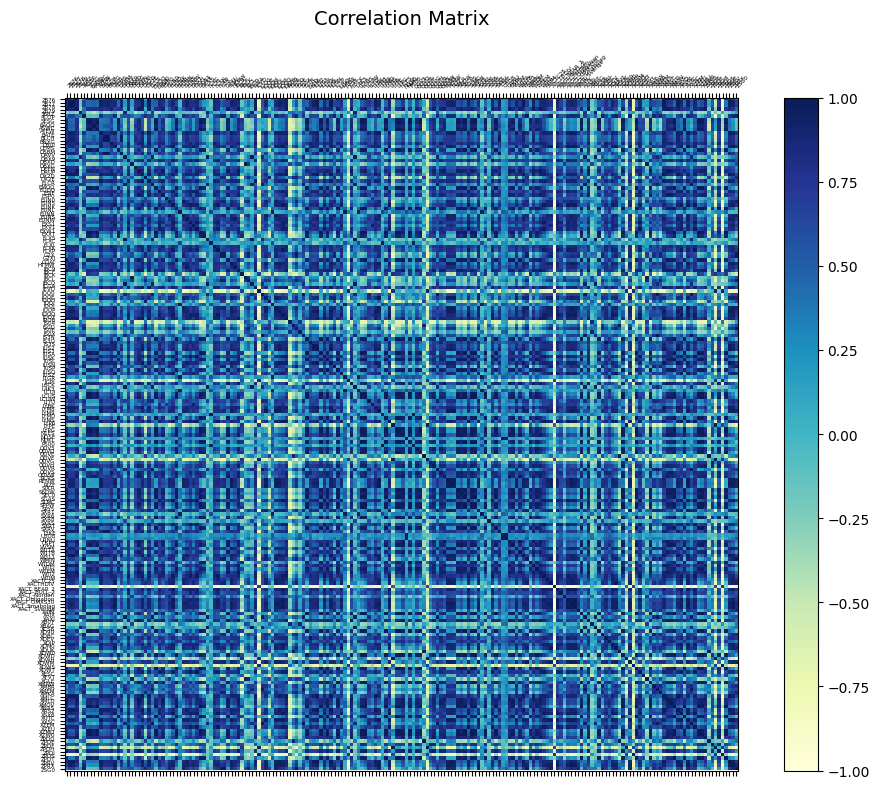

In [94]:


# Compute Returns and Statistics
_, mean_returns_daily, cov_matrix_daily = compute_returns_and_covariance_matrix(price_data)

# Annualize Metrics
mean_returns_annual, cov_matrix_annual = annualize_returns_and_covaraince_matrix(mean_returns_daily=mean_returns_daily, 
                                                                                 covariance_matrix_daily=cov_matrix_daily, 
                                                                                 trading_days_per_year=trading_days_per_year)


plot_correlation_matrix(cov_matrix_daily)



Bellow is a visualization of the average historical return of the assets in the data set. Note that the sizes of the squares are positively correlated with the average returns but not true to size.

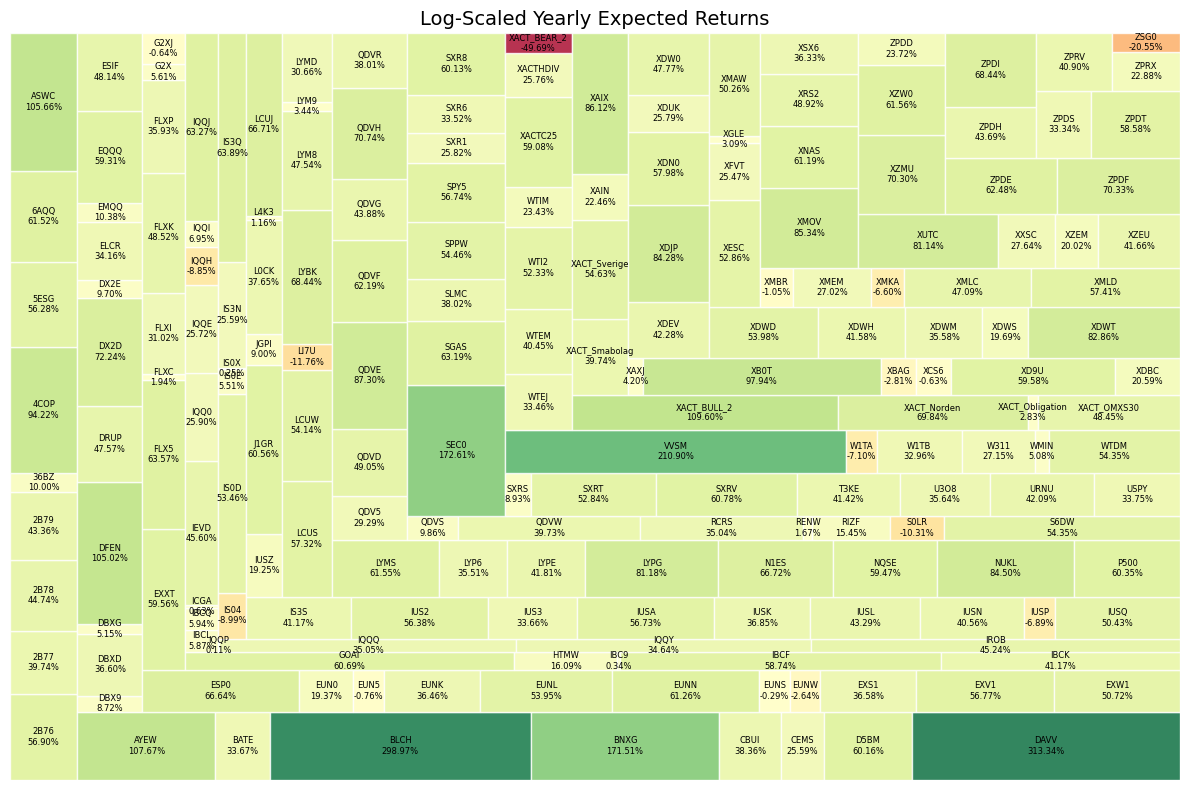

In [95]:

plot_return_square(price_data, trading_days_per_year=trading_days_per_year)

## The Efficient Frontier

In the following we will produce a portfolio by performing mean-variance optimization.

In the 1950's, economist Harry Markowitz introduced what is often referred to as *modern portfolio theory* (MPT) or *mean-variance portfolio optimization*. Markowitz theorized that an investor should base their investments on two things: the expected return and the expected risk. As such, he defined the optimal portfolio as one that minimizes the risk given a specific target return. In this regard, risk is defined as the portfolio variance, that is, the variance of the portfolio in a historical sense. Similarly, the expected return is defined as the average historical return of the portfolio. 

This definition of the optimal portfolio allows us to define a range of optimal portfolios, depending on the target return one wishes to achieve. If given a set of securities, we calculate their expected returns and let $r_{\mathrm{max}}$ denote the highest expected return. Then, this means we can construct portfolios with expected returns of at most $r_{\mathrm{max}}$. For any target return $r_{\mathrm{target}} \in [0, r_{\mathrm{max}}]$, we can determine the portfolio that minimizes the expected variance. Hence, there exists a curve in the return-variance plane on which these optimal portfolios lie. This curve is referred to as the *efficient frontier*.

The optimization problem is mathematically formulated as follows. Let $w$ denote the weights that one invests by in $n$ securities such that $w^\top \mathbf{1} = 1$. Additionally, let $\mu$ and $\Sigma$ denote the expected returns vector and covariance matrix respectively. Then the optimization problem is stated as:

$$
\begin{aligned}
\min_{w} & \quad w^\top \Sigma w, \\
\text{s.t.} & \quad w^\top \mu = r_{\mathrm{target}}, \\
            & \quad w^\top \mathbf{1} = 1.
\end{aligned}
$$

where $\mathbf{1} = (1, 1, \ldots)$ is a vector of ones of appropriate dimension. It can be shown that this problem is convex. The solution hereof for different values of $r_\mathrm{target} \in [0, r_{\mathrm{max}}]$ yields a curve like the one shown below.





Achievable Return Range: -49.69% to 313.34%


Optimizing Portfolios: 100%|██████████| 30/30 [00:19<00:00,  1.55it/s]


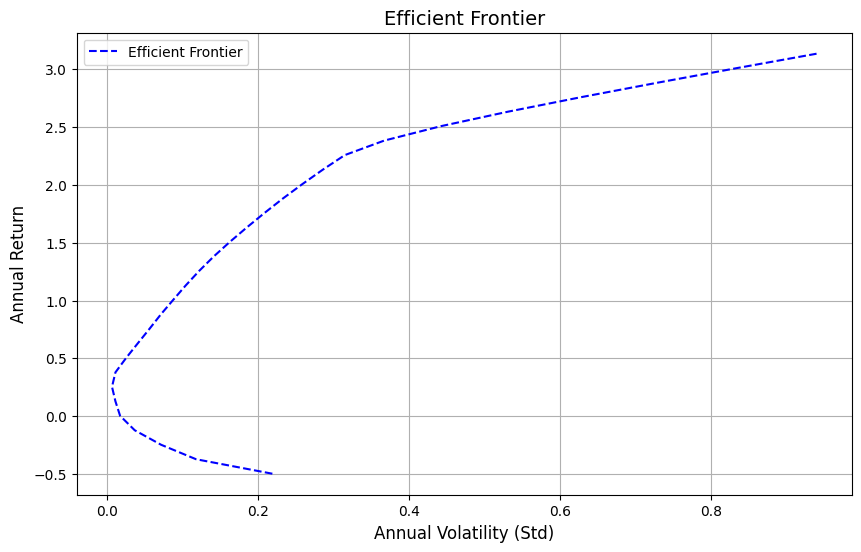

In [96]:
plot_efficient_frontier(
    mean_returns=mean_returns_annual,
    covariance_matrix=cov_matrix_annual,
    num_portfolios=30,
    max_assets=number_of_stocks_in_portfolio,
)


#### Choose the desired portfolio
In the cell bellow, please enter the desired expected **annual** return of the portfolio. You can choose any value from the efficient frontier.

In [97]:
target_return = np.mean(mean_returns_annual) # as an example, use average of means

print(f"Target return: {round(target_return*100, 2)}%")

Target return: 44.0%


#### The Market Portfolio

One portfolio that lies on the efficient frontier that is often preferred is the so-called *market portfolio*. This portfolio has the additional property of maximizing the Sharpe ratio.

##### Definition: Sharpe Ratio
Let $w$ denote a vector of weights constructing a portfolio of securities such that $w^\top \mathbf{1} = 1$. Let $\mu$ denote the average return of the securities in the portfolio, $\Sigma$ denote the corresponding covariance matrix, and $r_f$ denote the risk-free rate, assumed to be constant. Then the Sharpe ratio of the portfolio is defined as:

$$
S = \frac{w^\top \mu - r_f}{\sqrt{w}^\top \Sigma w},
$$

where $w^\top \mu$ is the average return of the portfolio with weights $w$, and $\sqrt{w}^\top \Sigma w$ is the standard deviation.
The Sharpe ratio describes a relationship between risk (variance) and reward (return). Under certain assumptions, the market portfolio consists of every available security weighted by its market value, hence the name. Note that so far, we have only considered how an investor can construct a portfolio optimally (in the mean-variance sense) by investing the entirety of the available capital in risky securities. However, in practice, it is often possible for an investor to earn a return without being subjected to risk, for instance by lending money. We refer to the constant rate of return that an investor can earn in this way as the *risk-free rate* $r_f$.

In [98]:

# The code bellow is used to calculate the desired portoflio and the 'market portfolio'

# Calculate Min-Variance Portfolio
w_minvar = compute_min_variance_portfolio(
    expected_returns=mean_returns_annual,
    covariance_matrix=cov_matrix_annual,
    target_return=target_return,
    max_assets=number_of_stocks_in_portfolio,
    verbose=False
)
if w_minvar is not None:
    minvar_dict = weights_to_dict(w_minvar, list(mean_returns_annual.index))
else:
    print(f"\nNo feasible solution for target return={target_return:.2%}.")


# Sharpe ratio maximization
w_maxsharpe = compute_max_sharpe_ratio_portfolio(
    expected_returns=mean_returns_annual,
    covariance_matrix=cov_matrix_annual,
    risk_free_rate=risk_free_rate_annual,
    max_assets=number_of_stocks_in_portfolio,
    verbose=True  # Ensure verbose is enabled for detailed output
)

if w_maxsharpe is not None:
    maxsharpe_dict = weights_to_dict(w_maxsharpe, list(mean_returns_annual.index))
    normalized_maxsharpe = round_portfolio(maxsharpe_dict, decimals=portfolio_precision+2)
else:
    print("\nNo feasible solution found for max Sharpe ratio portfolio.")


Covariance matrix is not positive definite. Applying regularization...
Regularization applied. Covariance matrix is now positive definite.

Starting stochastic variance targeting optimization...
Initial Sharpe Ratio: 8.855418
Iteration 1: Sharpe Ratio = 32.600682, Delta Improvement = 268.143911%
Iteration 2: Sharpe Ratio = 36.242794, Delta Improvement = 11.171890%
Iteration 3: Sharpe Ratio = 36.242794, Delta Improvement = 0.000000%

Optimization completed.
Total Iterations: 3
Final Sharpe Ratio: 36.242794


In [99]:
if w_maxsharpe is not None:
    print("\nMax Sharpe Ratio portfolio weights:\n")
    for asset, weight in normalized_maxsharpe.items():
        if weight != 0:
            print(f"{asset}: {weight}")


Max Sharpe Ratio portfolio weights:

ASWC: 0.017046551916
IBCQ: 0.016679380755
XACT_BEAR_2: 0.437554951948
XACT_BULL_2: 0.368429846344
XACT_Obligation: 0.007217442407
XACT_OMXS30: 0.061619652801
XACT_Sverige: 0.075809485736
ZPDS: 0.015642688092


You can choose the portfolio that maximizes the Sharpe-ratio by switching the lines bellow.

In [108]:
portfolio = round_and_prune_portfolio(maxsharpe_dict, decimals=portfolio_precision)  # 'market' portfolio
#portfolio = round_and_prune_portfolio(minvar_dict, decimals=portfolio_precision)  # Portfolio with desired expected return

## Results

The figure bellow attempts to visualize the found portfolio. The assets chosen for the portfolio appear in both subplots, with color and size indicating weight in the portfolio and position in the left subplot indicating the expected annual return and annual standard deviation of each asset. Note that 'SR' stands for Sharpe Ratio.

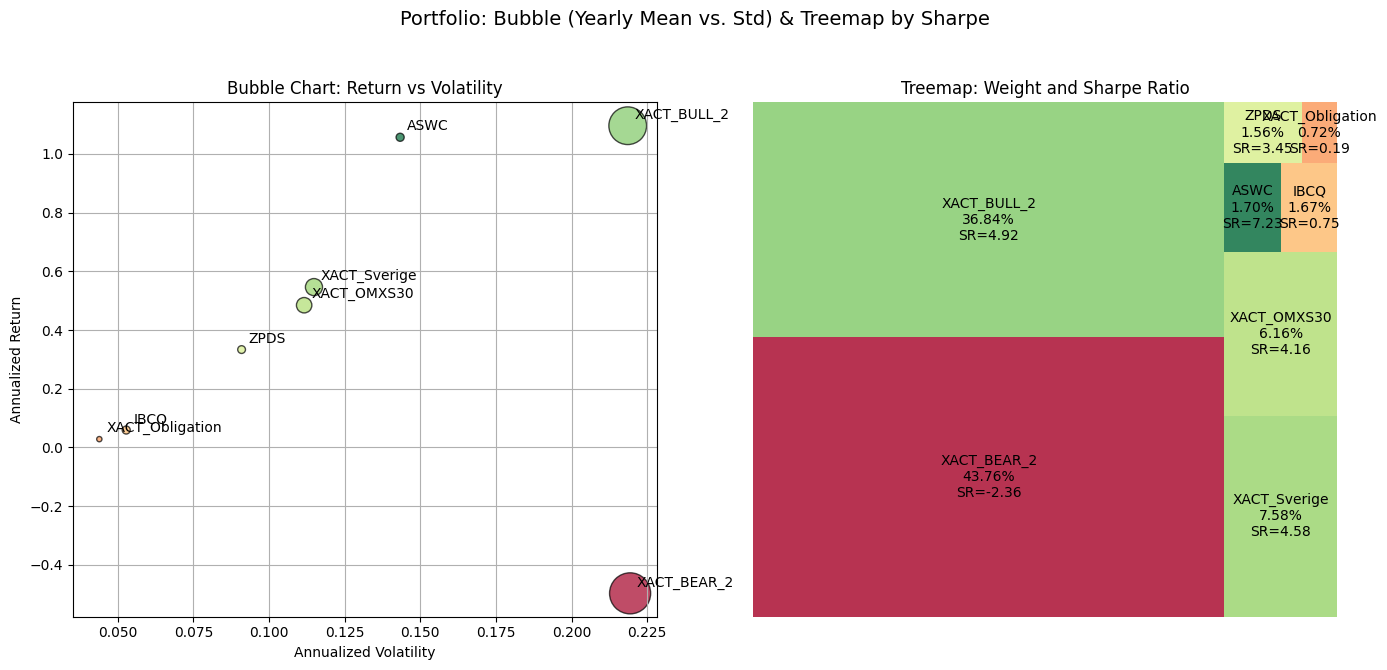

In [109]:
plot_portfolio(portfolio, price_data, trading_days_per_year=trading_days_per_year, risk_free_rate=risk_free_rate_annual)

The portfolio weights are shown bellow.

In [110]:
print("Portfolio:\n")
for asset in portfolio:
    if portfolio[asset] != 0:
        print(f"{asset}:", portfolio[asset])

Portfolio:

ASWC: 0.0170465519
IBCQ: 0.0166793808
XACT_BEAR_2: 0.4375549519
XACT_BULL_2: 0.3684298463
XACT_Obligation: 0.0072174424
XACT_OMXS30: 0.0616196528
XACT_Sverige: 0.0758094857
ZPDS: 0.0156426881


Bellow you can read the expected yearly return, standard deviation, and Sharpe ratio of the found portfolio.

In [111]:
calculate_portfolio_statistics(
    portfolio,
    mean_returns_annual=mean_returns_annual,
    covariance_matrix_annual=cov_matrix_annual,
    risk_free_rate=risk_free_rate_annual
)

Portfolio Expected Annual Return: 28.21%
Portfolio Annual Volatility (Std Dev): 0.72%
Portfolio Sharpe Ratio: 36.36


Note that the final portfolio might be worse than the one found during optimization. This is due to the rounding of percentages.